# PROJET DE STATISTIQUE DES RISQUES EXTREMES

*Mariane ALAPINI & Céleste NENEHIDINI*

## 0. Analyses préliminaires

**Importation des bibliothèques**

In [100]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import binomtest
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.special import gamma

**a. Importation des données**

Nous nous intéressons au cours du S&P 500.

In [37]:
TICKER = "SPY" # S&P 500 ETF

df = yf.download(TICKER, period="10y", interval="1d", auto_adjust=False)

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

last_close = df["Close"].iloc[-1]
print(f"Dernier Close {TICKER}: {last_close:.2f}")


df.to_csv(f"price_{TICKER}.csv")
print("CSV écrit:", f"price_{TICKER}.csv")

[*********************100%***********************]  1 of 1 completed

Dernier Close SPY: 686.90
CSV écrit: price_SPY.csv


**b. Vérification de la présence de valeurs manquantes**

In [38]:
df["Close"].isna().sum()

np.int64(0)

Pas de valeurs manquantes dans la série des prix à la clotûre.

**c. Calcul du log-rendement**

In [39]:
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
# Supprimer la première ligne qui est NaN après le calcul des log-rendements
df = df.dropna(subset=["log_return"])
df["log_return" ].head()

Date
2016-02-04    0.001567
2016-02-05   -0.019234
2016-02-08   -0.013552
2016-02-09    0.000054
2016-02-10   -0.000863
Name: log_return, dtype: float64

**d. Représentation graphique**

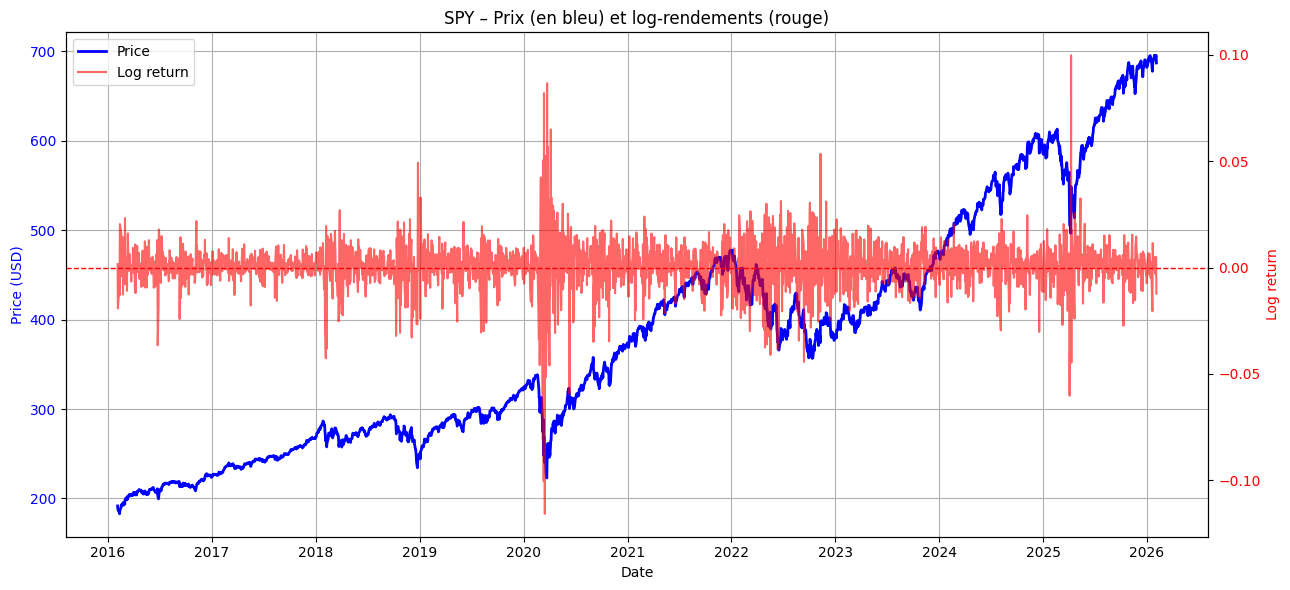

In [40]:
# Create figure
fig, ax1 = plt.subplots(figsize=(13, 6))

# Prix à le cloture 
ax1.plot(
    df.index,
    df["Close"],
    color="blue",
    linewidth=2,
    label="Price"
)
ax1.set_xlabel("Date")
ax1.set_ylabel("Price (USD)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True)

# Log-rendements
ax2 = ax1.twinx()
ax2.plot(
    df.index,
    df["log_return"],
    color="red",
    alpha=0.6,
    label="Log return"
)
ax2.axhline(0, color="red", linestyle="--", linewidth=1)
ax2.set_ylabel("Log return", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("SPY – Prix (en bleu) et log-rendements (rouge)")
plt.tight_layout()
plt.show()

**e. Méthode d'identification automatique des périodes de forte volatilité**

In [41]:
def detect_volatility_clusters(
    df,
    return_col="log_return",
    short_window=60,
    long_window=200,
    ratio_threshold=1.5,
    min_duration=3
):
    """
    Detect volatility clusters based on local vs long-term volatility divergence.

    Returns:
    - df with volatility measures and cluster flag
    - list of (start_date, end_date) clusters
    """
    df = df.copy()

    # Short-term and long-term volatility
    df["vol_short"] = df[return_col].rolling(short_window, center=False).std()
    df["vol_long"] = df[return_col].rolling(long_window, center=True).std()

    # Volatility ratio
    df["vol_ratio"] = df["vol_short"] / df["vol_long"]

    # Initial high-vol flag
    df["high_vol_flag"] = df["vol_ratio"] > ratio_threshold

    # ---- Extract clusters (bags) ----
    clusters = []
    start = None
    duration = 0

    for date, is_high in df["high_vol_flag"].items():
        if is_high:
            if start is None:
                start = date
                duration = 1
            else:
                duration += 1
        else:
            if start is not None and duration >= min_duration:
                clusters.append((start, date))
            start = None
            duration = 0

    # Edge case
    if start is not None and duration >= min_duration:
        clusters.append((start, df.index[-1]))

    return df, clusters

Explication de la démarche : à insérer

In [70]:
# Application de la détection des clusters
df_clusters, clusters = detect_volatility_clusters(
    df,
    return_col="log_return",
    short_window=60,
    long_window=250,
    ratio_threshold=1.2,
    min_duration=60
)

In [71]:
clusters

[(Timestamp('2018-02-09 00:00:00'), Timestamp('2018-05-14 00:00:00')),
 (Timestamp('2018-12-04 00:00:00'), Timestamp('2019-03-05 00:00:00')),
 (Timestamp('2020-03-13 00:00:00'), Timestamp('2020-06-12 00:00:00')),
 (Timestamp('2025-04-09 00:00:00'), Timestamp('2025-07-08 00:00:00'))]

In [54]:
def plot_returns_with_clusters(df, clusters, return_col="log_return", title=None):
    """
    Plot log-returns and highlight detected volatility clusters.
    - df: DataFrame indexé par dates
    - clusters: liste de tuples (start_date, end_date)
    """
    fig, ax = plt.subplots(figsize=(14, 5))

    # Série de rendements
    ax.plot(df.index, df[return_col], linewidth=1, label=return_col)

    # Surlignage des clusters (bandes verticales)
    for (start, end) in clusters:
        ax.axvspan(start, end, alpha=0.25)  # pas de couleur imposée

    ax.axhline(0, linewidth=1)
    ax.set_xlabel("Date")
    ax.set_ylabel("Log-return")
    ax.set_title(title if title else "Log-returns avec périodes de forte volatilité")
    ax.legend()
    plt.show()


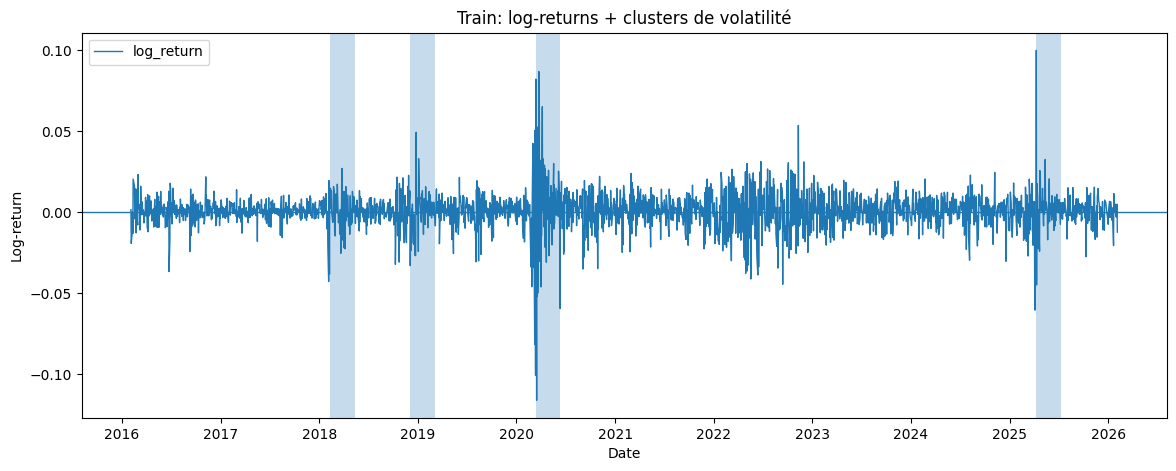

In [61]:
plot_returns_with_clusters(df_clusters, clusters, return_col="log_return",
                           title="Train: log-returns + clusters de volatilité")

**f. Découpage train/test**

On prend une période de forte volatilité d'au moins 60 jours, précédée d'une période de faible volatilité de 250 jours. 

In [56]:
df_simple = df[["Close", "log_return"]].copy()
df_simple.head()

Price,Close,log_return
Date,,
2016-02-04,191.600006,0.001567
2016-02-05,187.949997,-0.019234
2016-02-08,185.419998,-0.013552
2016-02-09,185.429993,0.000054
2016-02-10,185.270004,-0.000863


In [72]:
split_date1 = "2019-03-06"
split_date2 = "2020-03-12"
split_date3 = "2020-06-12"

train = df_simple.loc[
    (df_simple.index >= split_date1) &
    (df_simple.index <= split_date2)
]

test = df_simple.loc[
    (df_simple.index > split_date2) &
    (df_simple.index <= split_date3)
]

In [73]:
train.shape, test.shape

((258, 2), (64, 2))

On a bien deux échantillons de train et de test qui respectent les conditions requises.

**g. Statistiques descriptives sur les deux échantillons**

C:\Users\HP\AppData\Local\Temp\ipykernel_23204\3825776825.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=labels)


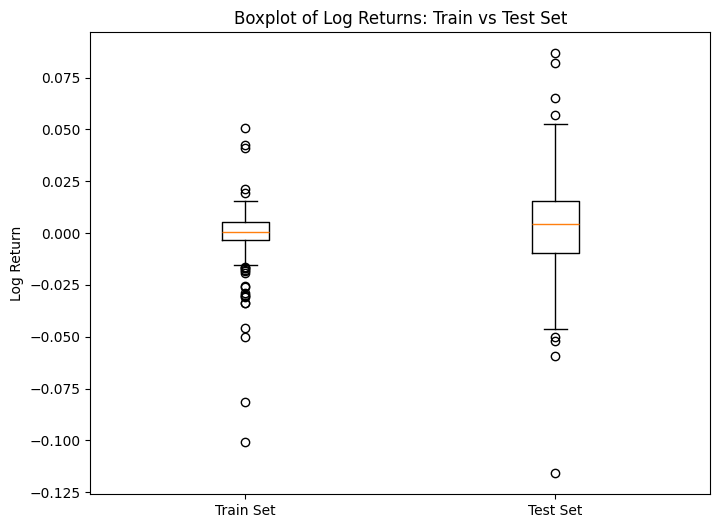

In [74]:
boxplot_data = [train["log_return"], test["log_return"]]
labels = ['Train Set', 'Test Set']
plt.figure(figsize=(8, 6))
plt.boxplot(boxplot_data, labels=labels)
plt.title('Boxplot of Log Returns: Train vs Test Set')
plt.ylabel('Log Return')
plt.show()

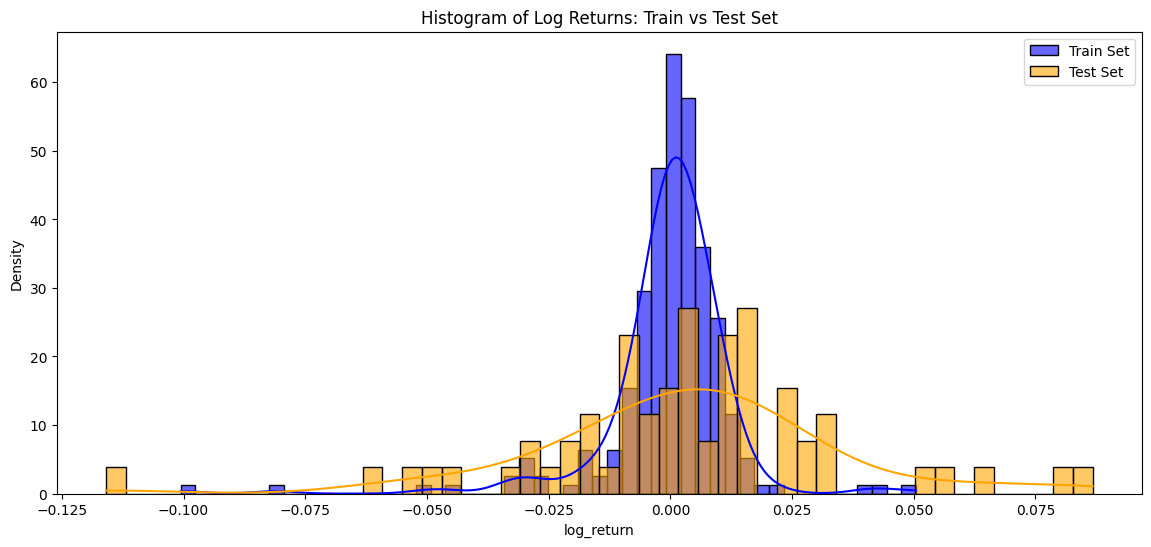

In [75]:
plt.figure(figsize=(14, 6))
sns.histplot(train["log_return"], bins=50, color='blue', label='Train Set', kde=True, stat="density", alpha=0.6)
sns.histplot(test["log_return"], bins=50, color='orange', label='Test Set', kde=True, stat="density", alpha=0.6)
plt.title('Histogram of Log Returns: Train vs Test Set')
plt.legend()
plt.show()

La distribution au niveau du test est beaucoup plus étalée et possède des queues plus lourdes.

In [76]:
train.describe()

Price,Close,log_return
count,258.000000,258.000000
mean,300.364999,-0.000455
std,16.232376,0.013394
min,248.110001,-0.100569
25%,288.625008,-0.003210
50%,297.309998,0.000598
75%,311.489998,0.005314
max,338.339996,0.050451


In [77]:
test.describe()

Price,Close,log_return
count,64.000000,64.000000
mean,280.611875,0.003185
std,23.422105,0.031725
min,222.949997,-0.115887
25%,265.062500,-0.009597
50%,284.020004,0.004240
75%,295.110001,0.015430
max,323.200012,0.086731


## 1. Calcul de la VAR non paramétrique

**a. Fonction calculant la VaR historique d’un ensemble de log-rendements**

In [80]:
def VaR_Hist(log_returns, alpha=0.99):
    """
    VaR historique à 1 jour au niveau alpha à partir de log-rendements.
    
    Paramètres
    ----------
    log_returns : array-like ou pd.Series
        Série de log-rendements (r_t).
    alpha : float
        Niveau de confiance (ex: 0.99 pour VaR 99%).

    Retour
    ------
    float
        VaR (positive), i.e. perte telle que P(L <= VaR) = alpha avec L = -r.
    """
    r = pd.Series(log_returns).dropna()

    # Quantile de la queue gauche des rendements
    q = np.quantile(r, 1 - alpha)

    # VaR en pertes (positive)
    return float(-q)


**b. VaR historique sur base d’apprentissage pour alpha = 99%**

In [81]:
VaR_99 = VaR_Hist(train["log_return"], alpha=0.99)
print(VaR_99)

0.047682334029621895


**c. Fonction calculant la VaR historique bootstrap d’un ensemble de log-rendements et donnant un IC de niveau alpha_IC de cette VaR**

In [82]:
def VaR_Hist_Bootstrap(log_returns, alpha=0.99, alpha_IC=0.95, B=2000, random_state=None):
    """
    VaR historique à 1 jour au niveau alpha + intervalle de confiance bootstrap (percentile)
    de niveau alpha_IC.

    Paramètres
    ----------
    log_returns : array-like ou pd.Series
        Série de log-rendements r_t.
    alpha : float
        Niveau de confiance de la VaR (ex: 0.99).
    alpha_IC : float
        Niveau de confiance de l'intervalle (ex: 0.95).
    B : int
        Nombre de réplications bootstrap.
    random_state : int ou None
        Graine pour reproductibilité.

    Retour
    ------
    var_hat : float
        VaR historique (positive), avec L = -r.
    ic : tuple(float, float)
        (borne_inf, borne_sup) de l'IC bootstrap percentile.
    """
    r = pd.Series(log_returns).dropna().to_numpy()
    n = r.size
    if n < 2:
        raise ValueError("La série doit contenir au moins 2 rendements non-NaN.")

    rng = np.random.default_rng(random_state)

    # Estimateur VaR historique sur l'échantillon
    q = np.quantile(r, 1 - alpha)
    var_hat = float(-q)

    # Bootstrap
    vars_boot = np.empty(B, dtype=float)
    for b in range(B):
        sample = rng.choice(r, size=n, replace=True)
        vars_boot[b] = -np.quantile(sample, 1 - alpha)

    # IC percentile (central)
    tail = (1 - alpha_IC) / 2
    lower = float(np.quantile(vars_boot, tail))
    upper = float(np.quantile(vars_boot, 1 - tail))

    return var_hat, (lower, upper)


In [83]:
var_99, ic_95 = VaR_Hist_Bootstrap(train["log_return"], alpha=0.99, alpha_IC=0.95, B=500, random_state=42)
print("VaR 99% :", var_99)
print("IC 95% :", ic_95)

VaR 99% : 0.047682334029621895
IC 95% : (0.030431956349950502, 0.08959274817734894)


**d. VaR historique bootstrap et l’IC associé à 90% sur base d’apprentissage pour alpha = 99%**

In [84]:
var_99, ic_90 = VaR_Hist_Bootstrap(train["log_return"], alpha=0.99, alpha_IC=0.90, B=500, random_state=42)
print("VaR 99% :", var_99)
print("IC 90% :", ic_90)

VaR 99% : 0.047682334029621895
IC 90% : (0.030770750603140915, 0.08959274817734894)


**e. Nombre d’exceptions sur base de test associées à la VaR historique calculée**

In [85]:
def nb_exceptions(test_returns, VaR):
    """
    Compte le nombre d'exceptions associées à une VaR donnée.

    Paramètres
    ----------
    test_returns : array-like ou pd.Series
        Log-rendements de l'échantillon test.
    VaR : float
        VaR à 1 jour (positive).

    Retour
    ------
    n_exc : int
        Nombre d'exceptions.
    rate_exc : float
        Taux d'exceptions.
    """
    r_test = pd.Series(test_returns).dropna().to_numpy()

    exceptions = r_test < -VaR
    n_exc = int(exceptions.sum())
    rate_exc = n_exc / len(r_test) if len(r_test) > 0 else np.nan

    return n_exc, rate_exc

In [86]:
n_exc, rate = nb_exceptions(test["log_return"], VaR_99)
print("Nombre d'exceptions :", n_exc)
print("Taux d'exceptions   :", rate)

Nombre d'exceptions : 4
Taux d'exceptions   : 0.0625


**f. Comparaison avec le niveau de risque attendu (IC de binomiale)**

In [ ]:
k = n_exc
n = test.shape[0]
p0 = 0.01          # attendu pour VaR 99%
alpha_IC = 0.9

# IC exact Clopper-Pearson
res = binomtest(k, n, p=p0, alternative="greater")
ci = res.proportion_ci(confidence_level=alpha_IC, method="exact")

print("Taux observé:", k/n)
print(f"IC {alpha_IC:.0%} (Clopper-Pearson): [{ci.low:.4f}, {ci.high:.4f}]")
print("p-value :", res.pvalue)


Taux observé: 0.0625
IC 90% (Clopper-Pearson): [0.0275, 1.0000]
p-value (trop d'exceptions): 0.003943523776313486


Le taux attendu sous une VaR 99% est 1%, et 1% n’appartient pas à cet intervalle de confiance calculée. Statistiquement, le taux d’exceptions observé est incompatible avec une VaR 99% bien calibrée. On a beaucoup trop d’exceptions et donc la VaR sous-estime le risque sur le test.

## 2. Calcul de la VaR Gaussienne

**a. Fonction calculant la VaR gaussienne d’un ensemble de log-rendements**

In [90]:
def VaR_Gauss(log_returns, alpha=0.99):
    """
    VaR gaussienne à 1 jour au niveau alpha.

    Paramètres
    ----------
    log_returns : array-like ou pd.Series
        Série de log-rendements.
    alpha : float
        Niveau de confiance (ex: 0.99).

    Retour
    ------
    float
        VaR gaussienne (positive).
    """
    r = pd.Series(log_returns).dropna()

    mu = r.mean()
    sigma = r.std(ddof=1)

    z = norm.ppf(1 - alpha)

    VaR = -(mu + sigma * z)
    return float(VaR)

**b. VaR gaussienne sur base d’apprentissage pour alpha = 99%**

In [91]:
VaR_gauss_99 = VaR_Gauss(train["log_return"], alpha=0.99)
print(VaR_gauss_99)

0.031613892245886614


**c. Validation ex-ante (analyses graphiques, QQ-plot, etc)**

In [92]:
def validation_ex_ante_gaussienne(log_returns, alpha=0.99, window_vol=20):
    """
    Validation ex-ante pour l'hypothèse gaussienne sur une série de log-rendements.
    - Série de rendements
    - Volatilité glissante (clustering)
    - Histogramme + fit normal
    - QQ-plot vs Normal(0,1) (standardisé)
    - Marque le quantile (1-alpha) théorique sous normalité (queue gauche)
    """
    r = pd.Series(log_returns).dropna()
    n = len(r)

    mu = r.mean()
    sigma = r.std(ddof=1)

    # standardisation
    z = (r - mu) / sigma

    # quantile queue gauche (rendements)
    q_emp = np.quantile(r, 1 - alpha)
    q_norm = mu + sigma * stats.norm.ppf(1 - alpha)

    # ---- 1) Rendements (time series) ----
    plt.figure(figsize=(12, 4))
    plt.plot(r.index, r.values)
    plt.axhline(q_emp, linestyle="--")
    plt.axhline(q_norm, linestyle="--")
    plt.title(f"Log-rendements (n={n}) et quantile (1-α) | α={alpha}")
    plt.xlabel("Date")
    plt.ylabel("log_return")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- 2) Volatilité glissante ----
    vol_roll = r.rolling(window_vol).std()
    plt.figure(figsize=(12, 4))
    plt.plot(vol_roll.index, vol_roll.values)
    plt.title(f"Volatilité glissante (std sur {window_vol} jours) — détection clustering")
    plt.xlabel("Date")
    plt.ylabel("rolling std")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- 3) Histogramme + fit normal ----
    plt.figure(figsize=(8, 4.8))
    plt.hist(r.values, bins=60, density=True)

    xs = np.linspace(r.min(), r.max(), 400)
    plt.plot(xs, stats.norm.pdf(xs, loc=mu, scale=sigma))
    plt.axvline(q_emp, linestyle="--", linewidth=1)
    plt.axvline(q_norm, linestyle="--", linewidth=1)
    plt.title("Histogramme des rendements + densité normale ajustée")
    plt.xlabel("log_return")
    plt.ylabel("densité")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- 4) QQ-plot (standardisé) ----
    plt.figure(figsize=(6, 6))
    stats.probplot(z.values, dist="norm", plot=plt)
    plt.title("QQ-plot des rendements standardisés vs N(0,1)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- 5) Statistiques simples (queue / asymétrie) ----
    skew = stats.skew(r.values, bias=False)
    kurt = stats.kurtosis(r.values, fisher=True, bias=False)  # excess kurtosis

    print(f"mu = {mu:.6f}, sigma = {sigma:.6f}")
    print(f"Quantile empirique (1-α) : {q_emp:.6f}")
    print(f"Quantile normal ajusté (1-α) : {q_norm:.6f}")
    print(f"Asymétrie (skewness) : {skew:.3f}")
    print(f"Kurtosis excédentaire : {kurt:.3f}  (0 si normal)")


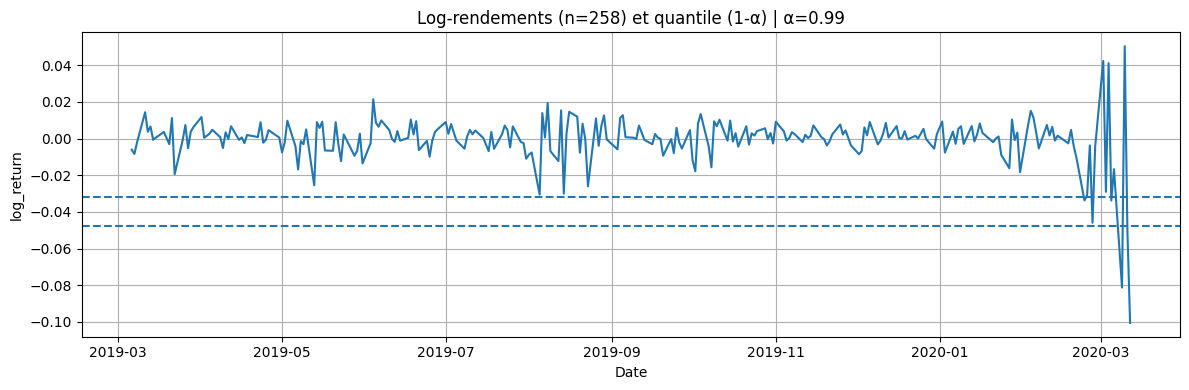

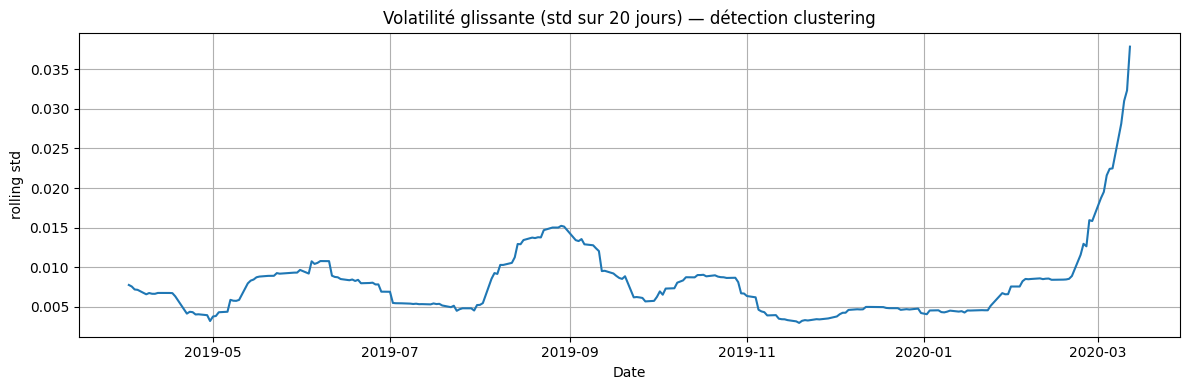

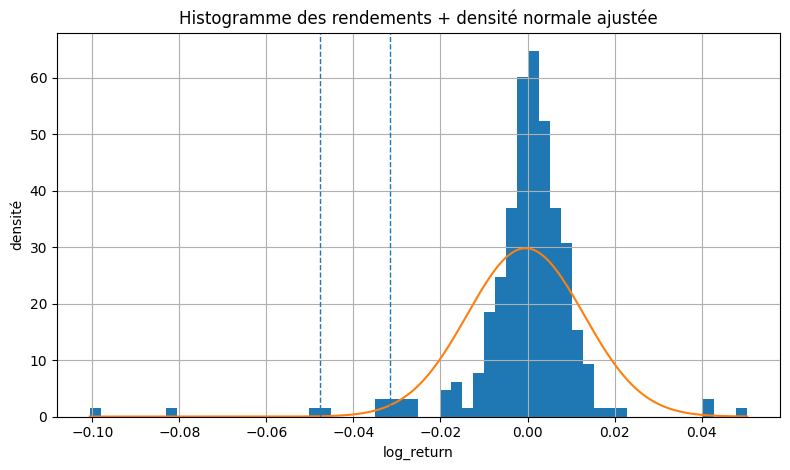

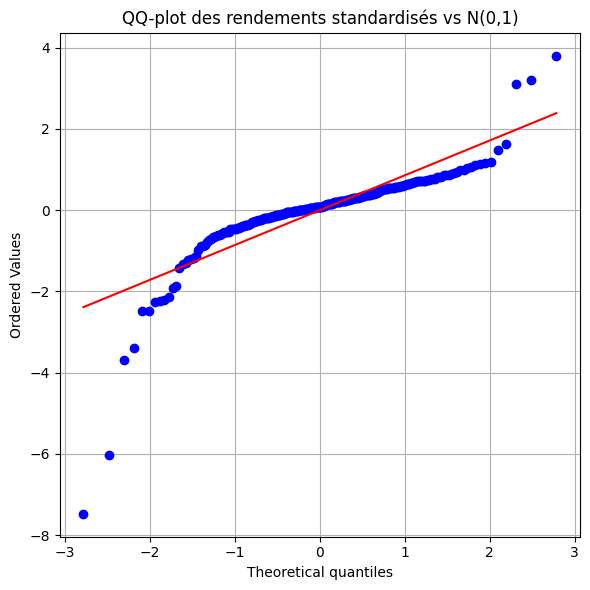

mu = -0.000455, sigma = 0.013394
Quantile empirique (1-α) : -0.047682
Quantile normal ajusté (1-α) : -0.031614
Asymétrie (skewness) : -2.681
Kurtosis excédentaire : 18.607  (0 si normal)


In [93]:
validation_ex_ante_gaussienne(train["log_return"], alpha=0.99, window_vol=20)

**d. VaR gaussienne à 10j par la méthode du scaling**

In [94]:
VaR_gauss_10j = VaR_gauss_99 * np.sqrt(10)
print(VaR_gauss_10j)

0.0999719052001376


**e. VaR gaussienne à 10j par méthode de diffusion d’un actif**

In [96]:
def var_gaussienne_diffusion(S0, mu, sigma, alpha=0.99, n_sims=200000, seed=42):
    rng = np.random.default_rng(seed)
    T = 10  # jours
    Z = rng.standard_normal(n_sims)

    # GBM exact sur horizon T
    ST = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    # perte (positive si baisse)
    loss = S0 - ST

    # VaR = quantile alpha des pertes
    return float(np.quantile(loss, alpha))

In [97]:
S0 = train["Close"].iloc[-1]
mu = train["log_return"].mean()
sigma = train["log_return"].std(ddof=1)

VaR_10j_99 = var_gaussienne_diffusion(S0, mu, sigma, alpha=0.99, n_sims=20000, seed=42)
print(VaR_10j_99)

24.612227500839627


Calcul précédent à revoir !!

In [98]:
def var_gaussienne_10j_rendement(mu, sigma, alpha=0.99):
    T = 10
    z = norm.ppf(1 - alpha)  # négatif
    return float(-(mu*T + sigma*np.sqrt(T)*z))  # VaR en % (positive)

VaR_10j_99 = var_gaussienne_10j_rendement(mu, sigma, alpha=0.99)
print(VaR_10j_99)

0.10308363140766805


In [99]:
S0 = float(train["Close"].iloc[-1])
mu = float(train["log_return"].mean())
sigma = float(train["log_return"].std(ddof=1))

VaR_10j_99 = var_gaussienne_diffusion(S0, mu, sigma, alpha=0.99, n_sims=20000, seed=42)
print(VaR_10j_99)


24.612227500839627


## 3. VaR skew-Student

**a. Estimation des paramètres d’une loi de Skew Student par maximum de vraisemblance**

In [101]:
# ----------------------------
# Skewed Student-t de Hansen (1994)
# Paramètres:
#   mu    : localisation
#   sigma : échelle (>0)
#   nu    : ddl (>2)
#   lam   : skewness dans (-1, 1)
# ----------------------------

def _hansen_constants(nu, lam):
    """
    Calcule a, b, c de Hansen (1994) pour la skewed t.
    """
    c = gamma((nu + 1) / 2) / (np.sqrt(np.pi * (nu - 2)) * gamma(nu / 2))
    a = 4 * lam * c * (nu - 2) / (nu - 1)
    b = np.sqrt(1 + 3 * lam**2 - a**2)
    return a, b, c

def skewt_pdf(x, mu, sigma, nu, lam):
    """
    PDF de la skewed t de Hansen (1994) évaluée en x (vectorisé).
    """
    x = np.asarray(x)
    if sigma <= 0 or nu <= 2 or not (-1 < lam < 1):
        return np.zeros_like(x, dtype=float)

    a, b, c = _hansen_constants(nu, lam)
    z = (x - mu) / sigma

    # seuil de bascule
    thresh = -a / b

    left = z < thresh
    right = ~left

    pdf = np.empty_like(z, dtype=float)

    # partie gauche
    denom_L = (1 - lam)
    arg_L = (b * z[left] + a) / denom_L
    pdf[left] = (b * c / sigma) * (1 + (arg_L**2) / (nu - 2)) ** (-(nu + 1) / 2)

    # partie droite
    denom_R = (1 + lam)
    arg_R = (b * z[right] + a) / denom_R
    pdf[right] = (b * c / sigma) * (1 + (arg_R**2) / (nu - 2)) ** (-(nu + 1) / 2)

    return pdf

def skewt_loglik(params, x):
    """
    Log-vraisemblance (somme des log pdf).
    params = (mu, log_sigma, log_nu_minus2, atanh_lam)
    """
    mu, log_sigma, log_nu_m2, atanh_lam = params
    sigma = np.exp(log_sigma)
    nu = 2.0 + np.exp(log_nu_m2)      # garantit nu > 2
    lam = np.tanh(atanh_lam)          # garantit lam in (-1, 1)

    pdf = skewt_pdf(x, mu, sigma, nu, lam)
    # sécurité numérique
    eps = 1e-14
    return np.sum(np.log(pdf + eps))

def fit_skewt_mle(x, mu0=None, sigma0=None, nu0=8.0, lam0=0.0):
    """
    Estime (mu, sigma, nu, lam) par MLE avec scipy.optimize.minimize.
    """
    x = np.asarray(x)

    if mu0 is None:
        mu0 = np.mean(x)
    if sigma0 is None:
        sigma0 = np.std(x, ddof=1)

    # paramètres transformés initiaux
    p0 = np.array([
        mu0,
        np.log(max(sigma0, 1e-8)),
        np.log(max(nu0 - 2.0, 1e-6)),
        np.arctanh(np.clip(lam0, -0.999, 0.999))
    ], dtype=float)

    # on maximise loglik => on minimise -loglik
    def objective(p):
        return -skewt_loglik(p, x)

    res = minimize(objective, p0, method="L-BFGS-B")

    mu_hat, log_sigma_hat, log_nu_m2_hat, atanh_lam_hat = res.x
    sigma_hat = np.exp(log_sigma_hat)
    nu_hat = 2.0 + np.exp(log_nu_m2_hat)
    lam_hat = np.tanh(atanh_lam_hat)

    out = {
        "mu": mu_hat,
        "sigma": sigma_hat,
        "nu": nu_hat,
        "lam": lam_hat,
        "success": res.success,
        "message": res.message,
        "fun": res.fun,  # valeur min de -loglik
        "loglik": -res.fun
    }
    return out

**b. Paramètres de loi Skew Student sur base d’apprentissage**

In [102]:
# Fit skew-t
skewt_fit = fit_skewt_mle(train['log_return'], nu0=8.0, lam0=0.0)
print("Skew-t MLE:", skewt_fit)

# Fit gaussien (MLE fermé)
mu_g, sigma_g = np.mean(train['log_return']), np.std(train['log_return'], ddof=1)
print("Gaussian:", {"mu": mu_g, "sigma": sigma_g})

Skew-t MLE: {'mu': np.float64(1.9446154216579448e-05), 'sigma': np.float64(0.03968265178479312), 'nu': np.float64(2.040149627568782), 'lam': np.float64(-0.15921050551038893), 'success': True, 'message': 'CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH', 'fun': np.float64(-845.3678005271676), 'loglik': np.float64(845.3678005271676)}
Gaussian: {'mu': np.float64(-0.00045508227051042644), 'sigma': np.float64(0.013393873858277987)}


**c. Validation ex-ante par QQ-plot**

In [103]:
def sample_skewt_hansen(n, mu, sigma, nu, lam, rng=None):
    """
    Génération par transformation:
    - On génère une Student-t symétrique t_nu
    - On applique la transformation piecewise de Hansen sur z
    - puis x = mu + sigma*z
    """
    if rng is None:
        rng = np.random.default_rng()

    a, b, c = _hansen_constants(nu, lam)

    # Student t symétrique standard (moyenne 0)
    # On génère via ratio normal / sqrt(chi2/nu)
    z0 = rng.standard_normal(n)
    u  = rng.chisquare(df=nu, size=n)
    t  = z0 / np.sqrt(u / nu)

    # On applique la transformation inverse de la définition piecewise
    # Hansen définit la densité en fonction de z, avec seuil -a/b
    # Ici on transforme t -> z en inversant l'argument piecewise.
    # On utilise la même séparation via probabilité implicite:
    # plus simple: on utilise la construction équivalente:
    #   z = ((1-lam)*t - a)/b si t < 0
    #   z = ((1+lam)*t - a)/b si t >= 0
    # Cette construction est couramment utilisée avec cette paramétrisation.
    z = np.empty_like(t)
    neg = t < 0
    z[neg]  = ((1 - lam) * t[neg]  - a) / b
    z[~neg] = ((1 + lam) * t[~neg] - a) / b

    return mu + sigma * z

def qqplot_gaussian(x, mu, sigma, title="QQ-plot Gaussian"):
    x = np.asarray(x)
    x_sorted = np.sort(x)
    n = len(x_sorted)
    p = (np.arange(1, n+1) - 0.5) / n
    theo = norm.ppf(p, loc=mu, scale=sigma)

    plt.figure()
    plt.plot(theo, x_sorted, marker='o', linestyle='none')
    # droite 45° (référence)
    mn = min(theo.min(), x_sorted.min())
    mx = max(theo.max(), x_sorted.max())
    plt.plot([mn, mx], [mn, mx])
    plt.title(title)
    plt.xlabel("Quantiles théoriques")
    plt.ylabel("Quantiles empiriques")
    plt.show()

def qqplot_skewt_sim(x, fit, nsim=200000, seed=123, title="QQ-plot Skew-t (simulation)"):
    x = np.asarray(x)
    x_sorted = np.sort(x)
    n = len(x_sorted)
    p = (np.arange(1, n+1) - 0.5) / n

    rng = np.random.default_rng(seed)
    sim = sample_skewt_hansen(nsim, fit["mu"], fit["sigma"], fit["nu"], fit["lam"], rng=rng)
    sim_sorted = np.sort(sim)

    # quantiles simulés aux mêmes probabilités
    idx = np.clip((p * (nsim - 1)).astype(int), 0, nsim - 1)
    theo = sim_sorted[idx]

    plt.figure()
    plt.plot(theo, x_sorted, marker='o', linestyle='none')
    mn = min(theo.min(), x_sorted.min())
    mx = max(theo.max(), x_sorted.max())
    plt.plot([mn, mx], [mn, mx])
    plt.title(title)
    plt.xlabel("Quantiles théoriques (skew-t simulée)")
    plt.ylabel("Quantiles empiriques")
    plt.show()

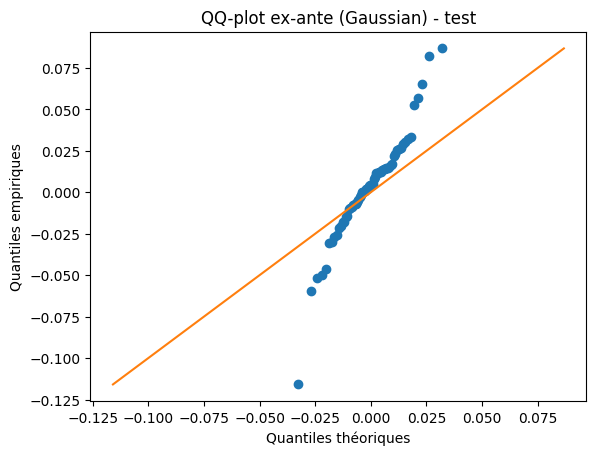

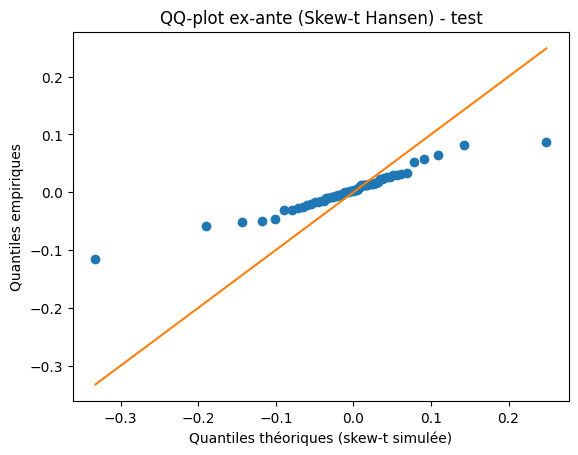

In [104]:
# QQ-plots ex-ante sur test
qqplot_gaussian(test['log_return'], mu_g, sigma_g, title="QQ-plot ex-ante (Gaussian) - test")
qqplot_skewt_sim(test['log_return'], skewt_fit, nsim=300000, seed=1, title="QQ-plot ex-ante (Skew-t Hansen) - test")

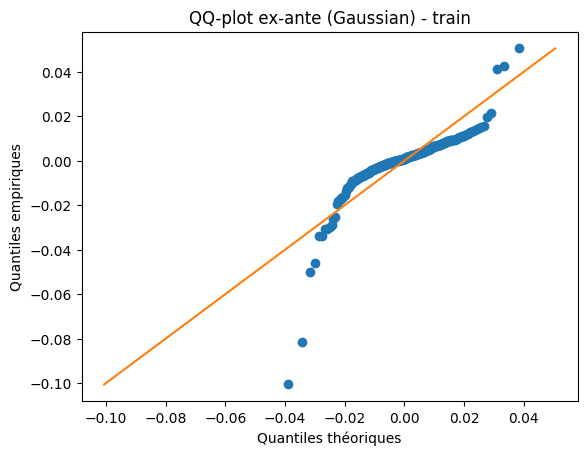

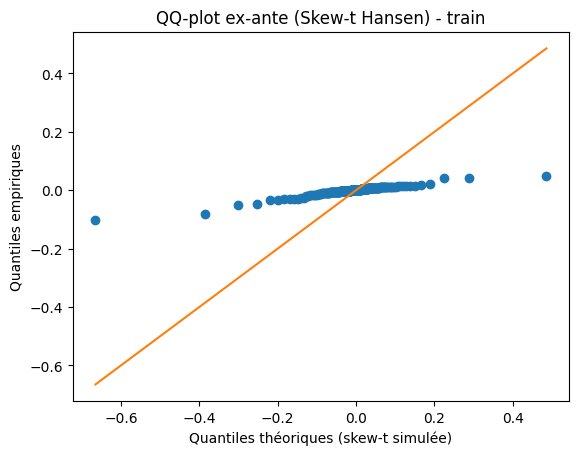

In [105]:
# QQ-plots ex-ante sur train
qqplot_gaussian(train['log_return'], mu_g, sigma_g, title="QQ-plot ex-ante (Gaussian) - train")
qqplot_skewt_sim(train['log_return'], skewt_fit, nsim=300000, seed=1, title="QQ-plot ex-ante (Skew-t Hansen) - train")

**d. Comparaison de la qualité de fit entre loi gaussienne et loi de skew Student par analyse graphique**

In [106]:
def plot_fit_comparison(x, mu_g, sigma_g, skewt_fit, bins=60, title="Fit comparison (train)"):
    x = np.asarray(x)
    grid = np.linspace(np.percentile(x, 0.5), np.percentile(x, 99.5), 800)

    pdf_g = norm.pdf(grid, loc=mu_g, scale=sigma_g)
    pdf_s = skewt_pdf(grid, skewt_fit["mu"], skewt_fit["sigma"], skewt_fit["nu"], skewt_fit["lam"])

    plt.figure()
    plt.hist(x, bins=bins, density=True, alpha=0.4)
    plt.plot(grid, pdf_g, label="Gaussian")
    plt.plot(grid, pdf_s, label="Skew-t (Hansen)")
    plt.title(title)
    plt.xlabel("Rendement")
    plt.ylabel("Densité")
    plt.legend()
    plt.show()

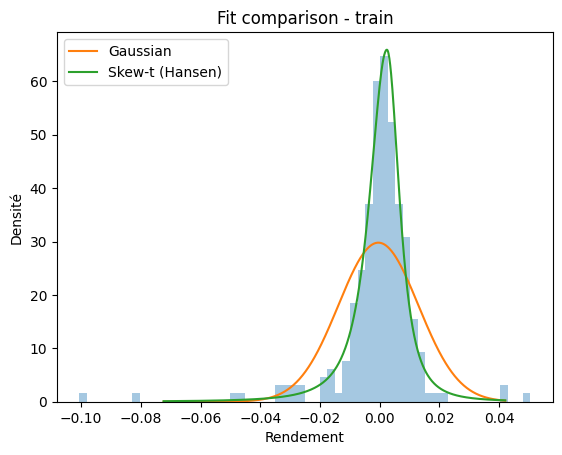

In [107]:
plot_fit_comparison(train['log_return'], mu_g, sigma_g, skewt_fit, title="Fit comparison - train")

**e. VaR Skew Student sur base d’apprentissage pour alpha = 99%**

In [108]:
def var_skewt_99_train(skewt_fit, nsim=2_000_000, seed=42):
    rng = np.random.default_rng(seed)
    sim = sample_skewt_hansen(nsim, skewt_fit["mu"], skewt_fit["sigma"], skewt_fit["nu"], skewt_fit["lam"], rng=rng)
    q01 = np.quantile(sim, 0.01)      # 1% quantile (rendements)
    VaR99 = -q01                      # VaR positive (perte)
    return VaR99, q01

VaR99_skewt, q01_skewt = var_skewt_99_train(skewt_fit, nsim=1_000_000, seed=7)
print("Skew-t: q01 (returns) =", q01_skewt, "| VaR99 (loss) =", VaR99_skewt)

# Pour comparaison: VaR gaussienne
q01_gauss = norm.ppf(0.01, loc=mu_g, scale=sigma_g)
VaR99_gauss = -q01_gauss
print("Gaussian: q01 (returns) =", q01_gauss, "| VaR99 (loss) =", VaR99_gauss)

Skew-t: q01 (returns) = -0.2995571792358924 | VaR99 (loss) = 0.2995571792358924
Gaussian: q01 (returns) = -0.031613892245886614 | VaR99 (loss) = 0.031613892245886614
